# 🛠 Labeling Function Development in Snorkel

In the [Introductory Tutorial](https://github.com/snorkel-team/snorkel-tutorials/blob/master/spam/spam_tutorial.ipynb),
we created our training set using a wide range of labeling functions spanning pattern matching,
weak supervision, and weak models.
However, these LFs weren't the first ideas that popped into our heads.
Typical LF development cycles include multiple iterations of ideation, refining, evaluation, and debugging.
In this notebook, we walk through the development of two LFs using basic analysis tools in Snorkel.

If you haven't done the [Introductory Tutorial](https://github.com/snorkel-team/snorkel-tutorials/blob/master/spam/spam_tutorial.ipynb) yet, we recommend you do that first.
We'll use the same [YouTube comments dataset](https://www.kaggle.com/goneee/youtube-spam-classifiedcomments) from Kaggle. Let's get to work!

## Recommended practice for LF development

Labeling function development is typically an iterative, creative, and free-form process.
However, there are a few principles that we highly recommend using when developing labeling functions.

* **Use the unlabeled training set for ideation whenever possible.** Reserve labeled examples for evaluation in order to avoid overfitting LFs or models.
* **Develop labeling functions in isolation.** Avoid using a "boosting" approach, trying to develop LFs specifically to interact with behavior of existing LFs. If you use the existing LFs to identify uncovered areas of the data, generalize the observed pattern rather than writing an LF to cover those exact examples.
* **Prioritize precision over coverage, up to 90% precision.** Precise LFs often result in higher performance models than ones with more coverage. However, coverage is often more difficult to obtain. So choose a 90% precision and 30% coverage version of an LF over a 95% precision and 10% coverage version.


## Loading training and development set data

In the [Introductory Tutorial](https://github.com/snorkel-team/snorkel-tutorials/blob/master/spam/spam_tutorial.ipynb), we covered the key data set splits in Snorkel development.
For LF development, we only need the training set (a large amount of unlabeled data) and the dev set (a large amount of labeled data).

In [1]:
import os

# Make sure we're running from the spam/ directory
if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spam")

In [2]:
from utils import load_spam_dataset

df_train, df_dev, _, _ = load_spam_dataset()

# We pull out the label vectors for ease of use later
Y_dev = df_dev["label"].values


# Define label-to-int mapping for legibility
SPAM = 1
HAM = 0
ABSTAIN = -1

## Initial ideation

Following recommended practice above, we'll start by looking at the training set to generate some ideas for LFs.

In [3]:
df_train[["author", "text", "video"]].sample(20, random_state=2)

,author,text,video
4,ambareesh nimkar,"""eye of the tiger"" ""i am the champion"" seems l...",2
87,pratik patel,"mindblowing dance.,.,.superbbb song﻿",3
14,RaMpAgE420,Check out Berzerk video on my channel ! :D,4
80,Jason Haddad,"Hey, check out my new website!! This site is a...",1
104,austin green,Eminem is my insperasen and fav﻿,4
305,M.E.S,hey guys look im aware im spamming and it piss...,4
22,John Monster,Οh my god ... Roar is the most liked video at ...,2
338,Alanoud Alsaleh,I started hating Katy Perry after finding out ...,2
336,Leonardo Baptista,http://www.avaaz.org/po/petition/Youtube_Corpo...,1
143,UKz DoleSnacher,Remove This video its wank﻿,1


One dominant pattern in the comments that look like spam is the use of the phrase "check out" (e.g. "check out my channel").
Let's start with that.

## Writing an LF to identify spammy comments that use the phrase "check out"

Let's start developing an LF to catch instances of commenters trying to get people to "check out" their channel, video, or website.
We'll start by just looking for the exact string `"check out"` in the text, and compare that to looking for just `"check"` in the text.

In [4]:
from snorkel.labeling.lf import labeling_function


@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.text.lower() else ABSTAIN


@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN

Let's generate our label matrices and see how we do.

In [5]:
from snorkel.labeling.apply import PandasLFApplier

lfs = [check_out, check]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)
L_dev = applier.apply(df_dev)

  0%|          | 0/1586 [00:00<?, ?it/s]

100%|██████████| 1586/1586 [00:00<00:00, 35927.17it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 25174.38it/s]

In [6]:
from snorkel.labeling.analysis import LFAnalysis

LFAnalysis(L_train, lfs).lf_summary().round(2)

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.21,0.21,0.0
check,1,[1],0.26,0.21,0.0


In [7]:
LFAnalysis(L_dev, lfs).lf_summary(Y_dev).round(2)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
check_out,0,[1],0.22,0.22,0.0,22,0,1.00
check,1,[1],0.30,0.22,0.0,29,1,0.97


So even these very simple rules do quite well!
Following our principle above, we might want to pick the `check` rule, since both have high precision and `check` has higher coverage.
But let's look at our error buckets to be sure.

In [8]:
from snorkel.analysis.error_analysis import error_buckets

buckets = error_buckets(Y_dev, L_dev[:, 1])
df_dev.iloc[buckets[(SPAM, HAM)]]

,author,date,text,label,video
260,Eanna Cusack,2014-01-20T22:20:59,Im just to check how much views it has﻿,0,1


`check` is still looking good, since the false positive is specific to only a few of the most popular videos on YouTube (ones with billions of views).
Now let's take a look at some places that `check` labeled `SPAM` on the training set to see if it matches our intuition or if we can identify some false positives.

In [9]:
df_train.iloc[L_train[:, 1] == SPAM].sample(10, random_state=1)

,author,date,text,label,video
305,M.E.S,NaN,hey guys look im aware im spamming and it piss...,-1.0,4
265,Kawiana Lewis,2015-02-27T02:20:40.987000,Check out this video on YouTube:opponents mm <...,-1.0,3
89,Stricker Stric,NaN,eminem new song check out my videos,-1.0,4
147,TheGenieBoy,NaN,check out fantasy music right here -------&...,-1.0,4
240,Made2Falter,2014-09-09T23:55:30,"Check out our vids, our songs are awesome! And...",-1.0,2
273,Artady,2014-08-11T16:27:55,https://soundcloud.com/artady please check my ...,-1.0,2
94,Nick McGoldrick,2014-10-27T13:19:06,Check out my drum cover of E.T. here! thanks -...,-1.0,2
139,MFkin PRXPHETZ,2014-01-20T09:08:39,"if you like raw talent, raw lyrics, straight r...",-1.0,1
303,이 정훈,NaN,"This great Warning will happen soon. ,0\nLneaD...",-1.0,4
246,media.uploader,NaN,Check out my channel to see Rihanna short mix ...,-1.0,4


No clear false positives here, but many look like they could be labeled by `check_out` as well.
Let's see where `check_out` abstained, but `check` labeled.

In [10]:
buckets = error_buckets(L_train[:, 0], L_train[:, 1])
df_train.iloc[buckets[(SPAM, ABSTAIN)]].sample(10, random_state=1)

,author,date,text,label,video
403,ownpear902,2014-07-22T18:44:36.299000,check it out free stuff for watching videos an...,-1.0,3
256,PacKmaN,2014-11-05T21:56:39,check men out i put allot of effort into my mu...,-1.0,1
196,Angek95,2014-11-03T22:28:56,"Check my channel, please!﻿",-1.0,1
282,CronicleFPS,2014-11-06T03:10:26,Check me out I'm all about gaming ﻿,-1.0,1
352,MrJtill0317,NaN,┏━━━┓┏┓╋┏┓┏━━━┓┏━━━┓┏┓╋╋┏┓ ┃┏━┓┃┃┃╋┃┃┃┏━┓┃┗┓┏...,-1.0,4
161,MarianMusicChannel,2014-08-24T03:57:52,"Hello! I'm Marian, I'm a singer from Venezuela...",-1.0,2
270,Kyle Jaber,2014-01-19T00:21:29,Check me out! I'm kyle. I rap so yeah ﻿,-1.0,1
292,Soundhase,2014-08-19T18:59:38,Hi Guys! check this awesome EDM &amp; House mi...,-1.0,2
179,Nerdy Peach,2014-10-29T22:44:41,Hey! I'm NERDY PEACH and I'm a new youtuber an...,-1.0,2
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1


Most of these seem like small modifications of "check out", like "check me out" or "check it out".
Let's see if we can use regular expressions to account for this and get the best of both worlds.

In [11]:
import re


@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

Again, let's generate our label matrices and see how we do.

In [12]:
lfs = [check_out, check, regex_check_out]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)
L_dev = applier.apply(df_dev)

  0%|          | 0/1586 [00:00<?, ?it/s]

100%|██████████| 1586/1586 [00:00<00:00, 25667.59it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 19302.79it/s]

In [13]:
LFAnalysis(L_train, lfs).lf_summary().round(2)

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.21,0.21,0.0
check,1,[1],0.26,0.23,0.0
regex_check_out,2,[1],0.23,0.23,0.0


In [14]:
LFAnalysis(L_dev, lfs).lf_summary(Y_dev).round(2)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
check_out,0,[1],0.22,0.22,0.0,22,0,1.00
check,1,[1],0.30,0.29,0.0,29,1,0.97
regex_check_out,2,[1],0.29,0.29,0.0,29,0,1.00


We've split the difference in training set coverage, and increased our accuracy on the dev set to 100%!
This looks promising.
Let's verify that we corrected our false positive from before.

In [15]:
buckets = error_buckets(L_dev[:, 1], L_dev[:, 2])
df_dev.iloc[buckets[(ABSTAIN, SPAM)]]

,author,date,text,label,video
260,Eanna Cusack,2014-01-20T22:20:59,Im just to check how much views it has﻿,0,1


To understand the coverage difference between `check` and `regex_check_out`, let's take a look at the training set.
Remember: coverage isn't always good.
Adding false positives will increase coverage.

In [16]:
buckets = error_buckets(L_train[:, 1], L_train[:, 2])
df_train.iloc[buckets[(ABSTAIN, SPAM)]].sample(10, random_state=1)

,author,date,text,label,video
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1
99,Santeri Saariokari,2014-09-03T16:32:59,"Hey guys go to check my video name ""growtopia ...",-1.0,2
21,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,-1.0,1
239,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿,-1.0,1
288,Kochos,2014-01-20T17:08:37,i check back often to help reach 2x10^9 views ...,-1.0,1
65,by.Ovskiy,2014-10-13T17:09:46,"Rap from Belarus, check my channel:)﻿",-1.0,2
196,Angek95,2014-11-03T22:28:56,"Check my channel, please!﻿",-1.0,1
333,FreexGaming,2014-10-18T08:12:26,want to win borderlands the pre-sequel? check ...,-1.0,2
167,Brandon Pryor,2014-01-19T00:36:25,I dont even watch it anymore i just come here ...,-1.0,1
266,Zielimeek21,2013-11-28T21:49:00,I'm only checking the views﻿,-1.0,1


Most of these are SPAM, but a good number are false positives.
**To keep precision high (while not sacrificing much in terms of coverage), we'd choose our regex-based rule.**

## TextBlob

In [17]:
import matplotlib.pyplot as plt
from textblob import TextBlob


spam_polarities = [
    TextBlob(x.text).sentiment.polarity for _, x in df_dev.iterrows() if x.label == SPAM
]

ham_polarities = [
    TextBlob(x.text).sentiment.polarity for _, x in df_dev.iterrows() if x.label == HAM
]

plt.hist([spam_polarities, ham_polarities])
plt.title("TextBlob sentiment polarity scores")
plt.xlabel("Sentiment polarity score")
plt.ylabel("Count")
plt.legend(["Spam", "Ham"])
plt.show()

plt.hist([spam_polarities, ham_polarities], bins=[-0.5, 0, 0.5, 1])
plt.title("TextBlob sentiment polarity scores")
plt.xlabel("Sentiment polarity score")
plt.ylabel("Count")
plt.legend(["Spam", "Ham"])
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

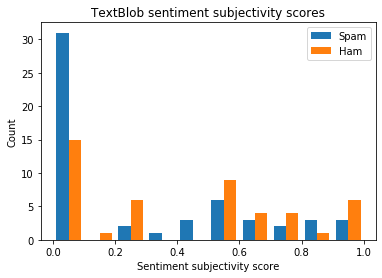

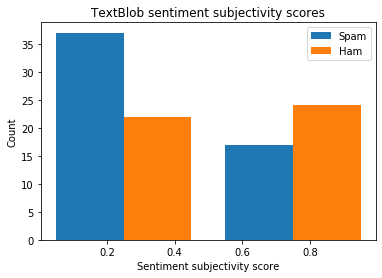

In [18]:
spam_subjectivities = [
    TextBlob(x.text).sentiment.subjectivity
    for _, x in df_dev.iterrows()
    if x.label == SPAM
]

ham_subjectivities = [
    TextBlob(x.text).sentiment.subjectivity
    for _, x in df_dev.iterrows()
    if x.label == HAM
]

plt.hist([spam_subjectivities, ham_subjectivities])
plt.title("TextBlob sentiment subjectivity scores")
plt.xlabel("Sentiment subjectivity score")
plt.ylabel("Count")
plt.legend(["Spam", "Ham"])
plt.show()

plt.hist([spam_subjectivities, ham_subjectivities], bins=[0, 0.5, 1])
plt.title("TextBlob sentiment subjectivity scores")
plt.xlabel("Sentiment subjectivity score")
plt.ylabel("Count")
plt.legend(["Spam", "Ham"])
plt.show()

In [19]:
from snorkel.labeling.preprocess import preprocessor


@preprocessor()
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x


textblob_sentiment.memoize = True


@labeling_function(preprocessors=[textblob_sentiment])
def textblob_polarity_ham(x):
    return HAM if not (-0.5 < x.polarity < 0.5) else ABSTAIN


@labeling_function(preprocessors=[textblob_sentiment])
def textblob_polarity_spam(x):
    return SPAM if -0.5 < x.polarity < 0.5 else ABSTAIN


@labeling_function(preprocessors=[textblob_sentiment])
def textblob_subjectivity_ham(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN


@labeling_function(preprocessors=[textblob_sentiment])
def textblob_subjectivity_spam(x):
    return SPAM if x.subjectivity < 0.5 else ABSTAIN

In [20]:
lfs = [
    textblob_polarity_ham,
    textblob_polarity_spam,
    textblob_subjectivity_ham,
    textblob_subjectivity_spam,
]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)
L_dev = applier.apply(df_dev)

  0%|          | 0/1586 [00:00<?, ?it/s]

  7%|▋         | 106/1586 [00:00<00:01, 1057.63it/s]

 13%|█▎        | 207/1586 [00:00<00:01, 901.08it/s] 

 20%|█▉        | 314/1586 [00:00<00:01, 944.33it/s]

 26%|██▋       | 419/1586 [00:00<00:01, 973.24it/s]

 33%|███▎      | 524/1586 [00:00<00:01, 992.79it/s]

 40%|███▉      | 630/1586 [00:00<00:00, 1010.38it/s]

 46%|████▋     | 737/1586 [00:00<00:00, 1025.40it/s]

 53%|█████▎    | 847/1586 [00:00<00:00, 1045.78it/s]

 60%|██████    | 958/1586 [00:00<00:00, 1061.80it/s]

 67%|██████▋   | 1067/1586 [00:01<00:00, 1068.26it/s]

 74%|███████▍  | 1173/1586 [00:01<00:00, 1064.78it/s]

 81%|████████  | 1279/1586 [00:01<00:00, 1061.59it/s]

 87%|████████▋ | 1387/1586 [00:01<00:00, 1065.74it/s]

 94%|█████████▍| 1494/1586 [00:01<00:00, 1066.14it/s]

100%|██████████| 1586/1586 [00:01<00:00, 1028.19it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1031.98it/s]

In [21]:
LFAnalysis(L_train, lfs).lf_summary().round(2)

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity_ham,0,[0],0.21,0.21,0.03
textblob_polarity_spam,1,[1],0.79,0.79,0.17
textblob_subjectivity_ham,2,[0],0.36,0.36,0.17
textblob_subjectivity_spam,3,[1],0.64,0.64,0.03


In [22]:
LFAnalysis(L_dev, lfs).lf_summary(Y_dev).round(2)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
textblob_polarity_ham,0,[0],0.19,0.19,0.03,15,4,0.79
textblob_polarity_spam,1,[1],0.81,0.81,0.25,50,31,0.62
textblob_subjectivity_ham,2,[0],0.41,0.41,0.25,24,17,0.59
textblob_subjectivity_spam,3,[1],0.59,0.59,0.03,37,22,0.63
